# Load data

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as K
import keras_tuner as kt

from utils import get_train_data, BASE_DIR

2022-03-09 21:57:37.201140: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


BASE_DIR: /home/andrew/Рабочий стол/Punch_DL


In [2]:
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
if sys.platform == 'linux':
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        print('GPU detected')
        
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

    tf.config.experimental.set_virtual_device_configuration(
        physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

GPU detected


2022-03-09 21:57:42.049749: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-03-09 21:57:42.138321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 21:57:42.139070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2022-03-09 21:57:42.139148: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-03-09 21:57:42.171783: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-03-09 21:57:42.191009: I tensorflow/stream_executor/pla

In [4]:
X_train, y_train, X_val, y_val = get_train_data(skip_midpoints=True, all_labels=True)

validation files
i1_hook_2
id4_hook_2
id0_jab_2
id2_jab_2
id4_jab_2
id2_uper_2
id3_uper_2
id4_uper_2

id1_hook_2 | reversed: False | data shape: (792, 34)
--------------------
id3_hook_1 | reversed: False | data shape: (1461, 34)
--------------------
id3_hook_2 | reversed: False | data shape: (1297, 34)
--------------------
id4_hook_1 | reversed: False | data shape: (1054, 34)
--------------------
id4_hook_2 | reversed: False | data shape: (1059, 34)
--------------------
id1_hook_1 | reversed: False | data shape: (858, 34)
--------------------
id2_hook_1 | reversed: False | data shape: (1013, 34)
--------------------
id0_hook_2 | reversed: False | data shape: (1051, 34)
--------------------
id0_hook_1 | reversed: False | data shape: (1100, 34)
--------------------
id2_hook_2 | reversed: False | data shape: (1041, 34)
--------------------
id3_jab_2 | reversed: False | data shape: (1164, 34)
--------------------
id4_jab_1 | reversed: False | data shape: (911, 34)
--------------------
id2

In [5]:
def compute_vector_angle(p0, p1, p2):
    # vector p0 - p1
    v1 = p0 - p1
    
    # vector p0 - p2
    v2 = p2 - p1
    
    v1_length = np.sqrt(v1[0] ** 2 + v1[1] ** 2)
    v2_length = np.sqrt(v2[0] ** 2 + v2[1] ** 2)
    
    cos = (v1[0] * v2[0] + v1[1] * v2[1]) / (v1_length * v2_length)
    
    if cos < -1:
        cos = -1
        
    if cos > 1:
        cos = 1

    return np.arccos(cos)


assert np.round(compute_vector_angle(np.array([2, 6]), np.array([0, 0]), np.array([8, 4])), 2) == 0.79


# nose            0,1
# left_eye        2,3
# right_eye       4,5
# left_ear        6,7
# right_ear       8,9
# left_shoulder   10,11
# right_shoulder  12,13
# left_elbow      14,15
# right_elbow     16,17
# left_wrist      18,19
# right_wrist     20,21

def add_angles(keypoints):
    return np.append(
        keypoints,
        [
            compute_vector_angle(keypoints[10:12], keypoints[14:16], keypoints[18:20]), # angle between left shoulder and wrist in radians
            compute_vector_angle(keypoints[12:14], keypoints[16:18], keypoints[20:22]), # angle between right shoulder and wrist in radians
        ])

In [6]:
X_train = np.apply_along_axis(add_angles, 1, X_train)
X_train.shape

(23642, 36)

In [7]:
X_val = np.apply_along_axis(add_angles, 1, X_val)
X_val.shape

(7432, 36)

In [8]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16,
    'angle': 17,
}

In [9]:
def format_feature_names(names):
    """"Form list of feature names

    Params:
        names - list of KEYPOINT_DICT keys
        ndims - number of dimensions (x, y, score)
        skip_midpoints - add or omit midpoint coords (x, y, score)

    Returns:
        list of feature names
    """
    feature_names = []
    for name in names:
        if 'angle' in name:
            feature_names.append(name+'-left-arm')
            feature_names.append(name+'-right-arm')
        else:
            feature_names.append(name+'-x')
            feature_names.append(name+'-y')

    return feature_names

In [10]:
feature_names = format_feature_names(list(KEYPOINT_DICT.keys()))

In [11]:
df = pd.DataFrame(data=X_train, columns=feature_names)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nose-x,23642.0,-0.219173,0.028361,-0.407440,-0.234674,-0.217196,-0.202192,0.361919
nose-y,23642.0,-0.140768,0.059893,-0.467713,-0.183845,-0.141331,-0.101649,0.475557
left_eye-x,23642.0,-0.230877,0.029497,-0.340693,-0.247528,-0.229086,-0.213395,0.359797
left_eye-y,23642.0,-0.137011,0.064951,-0.480470,-0.183367,-0.141739,-0.096620,0.477576
right_eye-x,23642.0,-0.232439,0.029792,-0.344901,-0.249345,-0.230018,-0.214672,0.359336
right_eye-y,23642.0,-0.133383,0.059181,-0.473905,-0.174492,-0.132322,-0.093929,0.475477
left_ear-x,23642.0,-0.232159,0.029205,-0.444675,-0.250282,-0.231409,-0.214035,0.366997
left_ear-y,23642.0,-0.091019,0.069892,-0.451503,-0.141887,-0.102860,-0.044005,0.474723
right_ear-x,23642.0,-0.236987,0.030313,-0.343276,-0.255230,-0.235268,-0.217955,0.363357
right_ear-y,23642.0,-0.080904,0.054617,-0.465192,-0.115119,-0.075604,-0.044110,0.473494


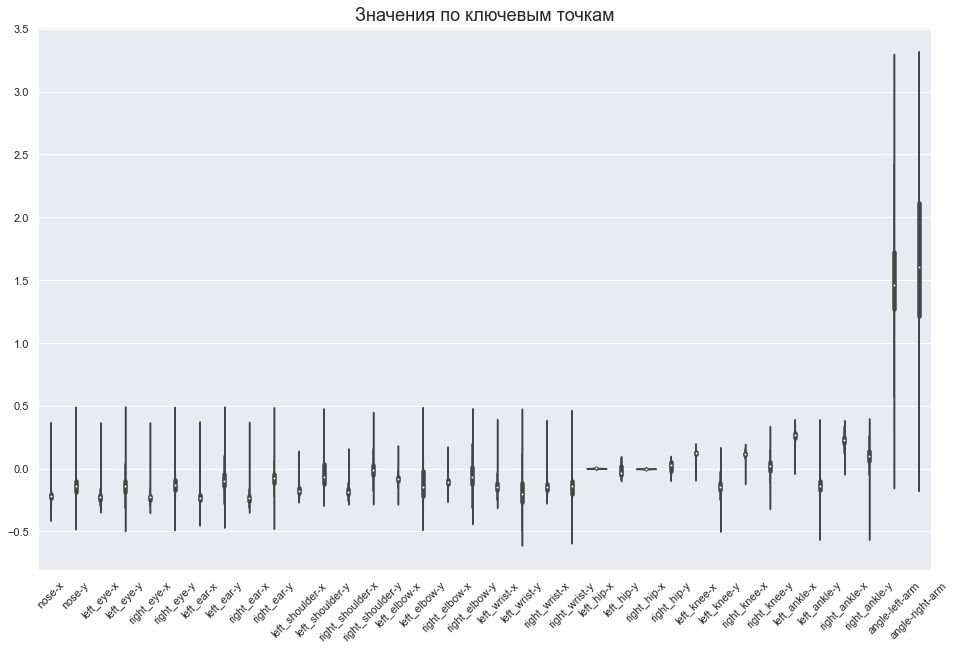

In [12]:
sns.set_theme()

plt.figure(figsize=(16, 10))
ax = sns.violinplot(data=df)
ax.set_title('Значения по ключевым точкам', fontsize=18)
_ = ax.set_xticklabels(df.keys(), rotation=45)
plt.savefig(BASE_DIR.joinpath('imgs', 'boxplot_keypoints.png'))
plt.show()

In [13]:
time_steps=30 # expect camera 30 fps, so process 1 sample per second
# Number of samples in batch
N_train = X_train.shape[0] // time_steps
N_val = X_val.shape[0] // time_steps

print(N_train)
print(N_val)

788
247


In [14]:
X_train = X_train[:N_train*time_steps].reshape(-1, time_steps, 36)
y_train = y_train[:N_train*time_steps].reshape(-1, time_steps, 1)

X_val = X_val[:N_val*time_steps].reshape(-1, time_steps, 36)[:-3]
y_val = y_val[:N_val*time_steps].reshape(-1, time_steps, 1)[:-3]

print(X_train.shape)
print(X_val.shape)

(788, 30, 36)
(244, 30, 36)


## LSTM

In [15]:
y_train = K.utils.to_categorical(y_train, num_classes=13)
X_train = tf.constant(X_train)

y_val = K.utils.to_categorical(y_val, num_classes=13)
X_val = tf.constant(X_val)

2022-03-09 21:57:56.825446: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-09 21:57:56.862396: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2295490000 Hz
2022-03-09 21:57:56.862933: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6421aa0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-09 21:57:56.862956: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-03-09 21:57:56.950851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-0

In [46]:
def model_builder(hp):
    # Hyperparams
    # lstm layer
    hp_ru = hp.Int('recurrent_units', min_value=128, max_value=256, step=32)
    hp_kernel_reg = hp.Float('kernel_reg', min_value=1e-6, max_value=1e-3, sampling='log')
    hp_recur_reg = hp.Float('recur_reg', min_value=1e-6, max_value=1e-3, sampling='log')
    hp_act_reg = hp.Float('act_reg', min_value=1e-6, max_value=1e-3, sampling='log')
    hp_dp = hp.Float('lstm_dp', min_value=0., max_value=0.4)
    hp_rec_dp = hp.Float('rec_dropout', min_value=0., max_value=0.4)
    
    # dense layers
    hp_du = hp.Int('units', min_value=64, max_value=256, step=32)
    hp_reg = hp.Float('dense_reg', min_value=1e-6, max_value=1e-3)
    hp_dl_dp = hp.Float('dropout', min_value=0., max_value=0.4)
    
    # Model
    model = K.Sequential([
        K.layers.InputLayer((30, 36), batch_size=4),
        K.layers.LayerNormalization(axis=1),
        K.layers.LSTM(hp_ru,
                           stateful=True, # mutable states not supported in tflite 
                           return_sequences=True,
                           kernel_regularizer=K.regularizers.l2(hp_kernel_reg),
                           recurrent_regularizer=K.regularizers.l2(hp_recur_reg),
                           activity_regularizer=K.regularizers.l2(hp_act_reg),
                           dropout=hp_dp,
                           recurrent_dropout=hp_rec_dp
                     ),
        K.layers.LayerNormalization(axis=1),
        K.layers.Dense(hp_du, activation='relu',
                            kernel_regularizer=K.regularizers.l2(hp_reg)),
        K.layers.Dropout(hp_dl_dp),
        K.layers.LayerNormalization(axis=1),
        K.layers.Dense(13, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [47]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=32,
                     directory=BASE_DIR.joinpath('kt_dir'),
                     project_name=BASE_DIR.joinpath('punch_dl_kt_lstm'))

stop_early = K.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(X_train, y_train, batch_size=4, validation_data=(X_val, y_val), epochs=32, shuffle=False, callbacks=[stop_early])

Trial 91 Complete [00h 05m 52s]
val_accuracy: 0.5734972953796387

Best val_accuracy So Far: 0.5734972953796387
Total elapsed time: 01h 52m 17s
INFO:tensorflow:Oracle triggered exit


In [48]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

{'recurrent_units': 128,
 'kernel_reg': 7.587187772196259e-06,
 'recur_reg': 3.585696719190882e-05,
 'act_reg': 0.0002989734747013008,
 'lstm_dp': 0.18880437192013716,
 'rec_dropout': 0.24741230808253367,
 'units': 224,
 'dense_reg': 0.0004094004870361379,
 'dropout': 0.3953466674576018,
 'tuner/epochs': 32,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [49]:
# Build the model with the optimal hyperparameters and train it on the data for 64 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, batch_size=4,
                    validation_data=(X_val, y_val),
                    epochs=64,
                    shuffle=False,
                    callbacks=[
                        K.callbacks.ReduceLROnPlateau(),
                        K.callbacks.ModelCheckpoint(filepath='checkpoints/lstm', save_weights_only=True),
                        K.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
                    ])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/64
197/197 [==============================] - 14s 70ms/step - loss: 2.5047 - accuracy: 0.3844 - val_loss: 2.2966 - val_accuracy: 0.4236
Epoch 2/64
197/197 [==============================] - 14s 72ms/step - loss: 2.0704 - accuracy: 0.4772 - val_loss: 2.0432 - val_accuracy: 0.4497
Epoch 3/64
197/197 [==============================] - 14s 70ms/step - loss: 1.9661 - accuracy: 0.4915 - val_loss: 1.9540 - val_accuracy: 0.4615
Epoch 4/64
197/197 [==============================] - 13s 67ms/step - loss: 1.8922 - accuracy: 0.5031 - val_loss: 1.9490 - val_accuracy: 0.4648
Epoch 5/64
197/197 [==============================] - 14s 69ms/step - loss: 1.8504 - accuracy: 0.5104 - val_loss: 1.8976 - val_accuracy: 0.4751
Epoch 6/64
197/197 [==============================] - 14s 72ms/step - loss: 1.8139 - accuracy: 0.5161 - val_loss: 1.8988 - val_accuracy: 0.4754
Epoch 7/64
197/197 [==============================] - 14s 69ms/step - loss: 1.7746 - accuracy: 0.5266 - val_loss: 1.8851 - val_accuracy:

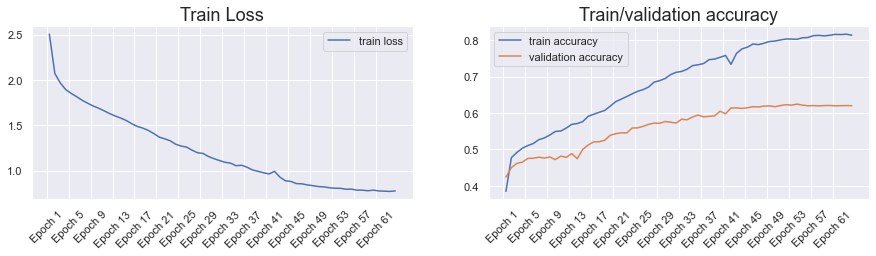

In [64]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title('Train Loss', fontsize=18)
plt.plot(history.history['loss'], label='train loss')
xticks1 = plt.xticks([i - 0.5 for i in range(len(history.history['loss']))],
           [f'Epoch {i + 1}' for i in range(len(history.history['loss']))], rotation=45)

for i, label in enumerate(xticks1[0]):
    if i % 4 == 0:
        pass
    else:
        label.set_visible(False)

plt.legend()
plt.subplot(222)
plt.title('Train/validation accuracy', fontsize=18)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
xticks2 = plt.xticks([i - 0.5 for i in range(len(history.history['loss']))],
           [f'Epoch {i + 1}' for i in range(len(history.history['loss']))], rotation=45)

for i, label in enumerate(xticks2[0]):
    if i % 4 == 0:
        pass
    else:
        label.set_visible(False)

plt.legend()
plt.savefig(BASE_DIR.joinpath('imgs', 'lstm_with_angles_kt_loss_and_acc.png'))
plt.show()

# Save model

In [55]:
model.save(BASE_DIR.joinpath('models', 'lstm__with_angles'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2022-03-10 00:34:07.293652: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/andrew/Рабочий стол/Punch_DL/models/lstm__with_angles/assets
